In [12]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

In [13]:
def compute_ring_radius(p,q):
    a = np.pi/p
    b = np.pi/q
    r0 = np.sqrt(np.cos(a+b)/np.cos(a-b))
    return r0

def hyperbolic_distance(kappa, z1, z2):
    d = kappa * np.arccosh(1 + (2 * (abs(z1 - z2))**2 / ((1 - abs(z1)**2) * (1 - abs(z2)**2))))
    return d

def unit_cell_positions(p,q):
    r0 = compute_ring_radius(p,q)
    vertices_positions = []
    for k in range(p):
        vertices_positions.append(r0 * np.exp(1j * np.pi * (2*k-1) / p))
    
    d0 = 0.66
    for k in range(p):
        vertices_positions.append(d0 * np.exp(1j * np.pi * (2*k-1) / p))
    
    return vertices_positions

def inner_ring_coords(p,q):
    vertices_positions = unit_cell_positions(p,q)
    vertices_coords = []
    for k in range(len(vertices_positions)):
        x,y = vertices_positions[k].real, vertices_positions[k].imag
        vertices_coords.append(np.array([x,y]))
    return vertices_coords

def euclidean_distance(z1, z2):
    d = abs(z1 - z2)
    return d

def rotation_matrix(phi):
    return np.array([[np.exp(1j*phi/2), 0], [0, np.exp(-1j*phi/2)]])

def Fuchsian_generators(p_B, q_B):
    alpha = 2* np.pi/ p_B
    beta = 2* np.pi/ q_B
    sigma = np.sqrt((np.cos(alpha) + np.cos(beta)) / (1 + np.cos(beta)) )
    gamma1 = 1/(np.sqrt(1-sigma**2)) * np.array([[1, sigma], [sigma,1]])
    FG_generators = []
    for mu in range(0,int(p_B/2)):
        gamma_j = rotation_matrix(mu*alpha) @ gamma1 @ rotation_matrix(-mu*alpha)
        FG_generators.append(gamma_j)
        FG_generators.append(np.linalg.inv(gamma_j))
    return FG_generators 

def create_new_vertex(vertex_position, translation_matrix):
    v = translation_matrix @ np.array([vertex_position, 1])
    new_vertex_position = v[0]/v[1]
    return new_vertex_position

def plot_vertices_with_edges(vertices):
    vertex_to_edges = {}
    edge_to_vertices = {}
    d0 = hyperbolic_distance(kappa, vertices[0], vertices[1])
    coords = [(v.real, v.imag) for v in vertices]
  
    G = nx.Graph()
    for idx, pos in enumerate(coords):
        G.add_node(idx, pos=pos, label=True)
        
    edge_count = 0  # Counter for edge labels
    
    for i, pos1 in enumerate(vertices):
        for j, pos2 in enumerate(vertices[i+1:], start=i+1):
            if hyperbolic_distance(kappa, pos1, pos2) < (d0 + 0.1):
                G.add_edge(i, j, with_labels=True)
                vertex_to_edges[(i, j)] = edge_count
                edge_to_vertices[edge_count] = (i,j)
                edge_count += 1            

    pos_dict = {idx: pos for idx, pos in enumerate(coords)}
    
    # Set figure size
    plt.figure(figsize=(40, 40))  # Adjust the width and height as needed
    
    # Draw the graph
    nx.draw(
        G,
        pos=pos_dict,
        node_size=80,  # Adjust node size
        node_color="lightblue",
        with_labels=True,
        font_size=18,  # Increase font size for node labels
        font_color="black"
    )
    
    # Draw edge labels
    nx.draw_networkx_edge_labels(
        G,
        pos=pos_dict,
        edge_labels=vertex_to_edges,
        font_size=10,  # Increase font size for edge labels
        label_pos=0.5,  # Adjust edge label position (closer to the center of edges)
    )
    
    plt.axis("equal")  # Ensure equal scaling
    # plt.show()  # Display the plot
    
    return G, vertex_to_edges, edge_to_vertices

def get_edge_labels_for_vertex(G, vertex, vertex_to_edges):
    # Get all edges incident to the given vertex
    incident_edges = list(G.edges(vertex))
    
    # Retrieve the labels for these edges from the vertex_to_edges dictionary
    incident_edge_labels = {edge: vertex_to_edges[tuple(sorted(edge))] for edge in incident_edges}

    
    return incident_edge_labels.values()

In [14]:
twelve_face_connections = {72: [109],
73: [94, 108],
74: [93, 143],
75: [120, 142],
76: [153, 127],
77: [152],
186: [31],
187: [30, 40],
188: [121, 47],
189: [120, 138],
190: [91, 137],
191: [90, 108],
184: [107, 61],
185: [60],
78: [171],
79: [170],
89: [174],
90: [173],
153: [30],
154: [29, 47],
155: [46, 56],
156: [105, 63],
157: [104, 122],
158: [121, 139],
159: [138],
92: [25],
93: [24],
94: [59],
95: [44, 58],
88: [43],
106: [175],
107: [174],
109: [58],
110: [43, 57],
111: [28, 42],
104: [27],
123: [168],
124: [175, 57],
125: [42, 56],
126: [27, 41],
127: [26],
140: [41],
141: [26, 40],
142: [25],
143: [60],
136: [173, 59],
137: [172],
168: [45],
169: [44, 62],
170: [61]}

#TODO Double check the correction of these connections
one_face_connections = {
    8: [12,13],
    9: [12,13],
    10: [14, 15],
    11: [14, 15],
}

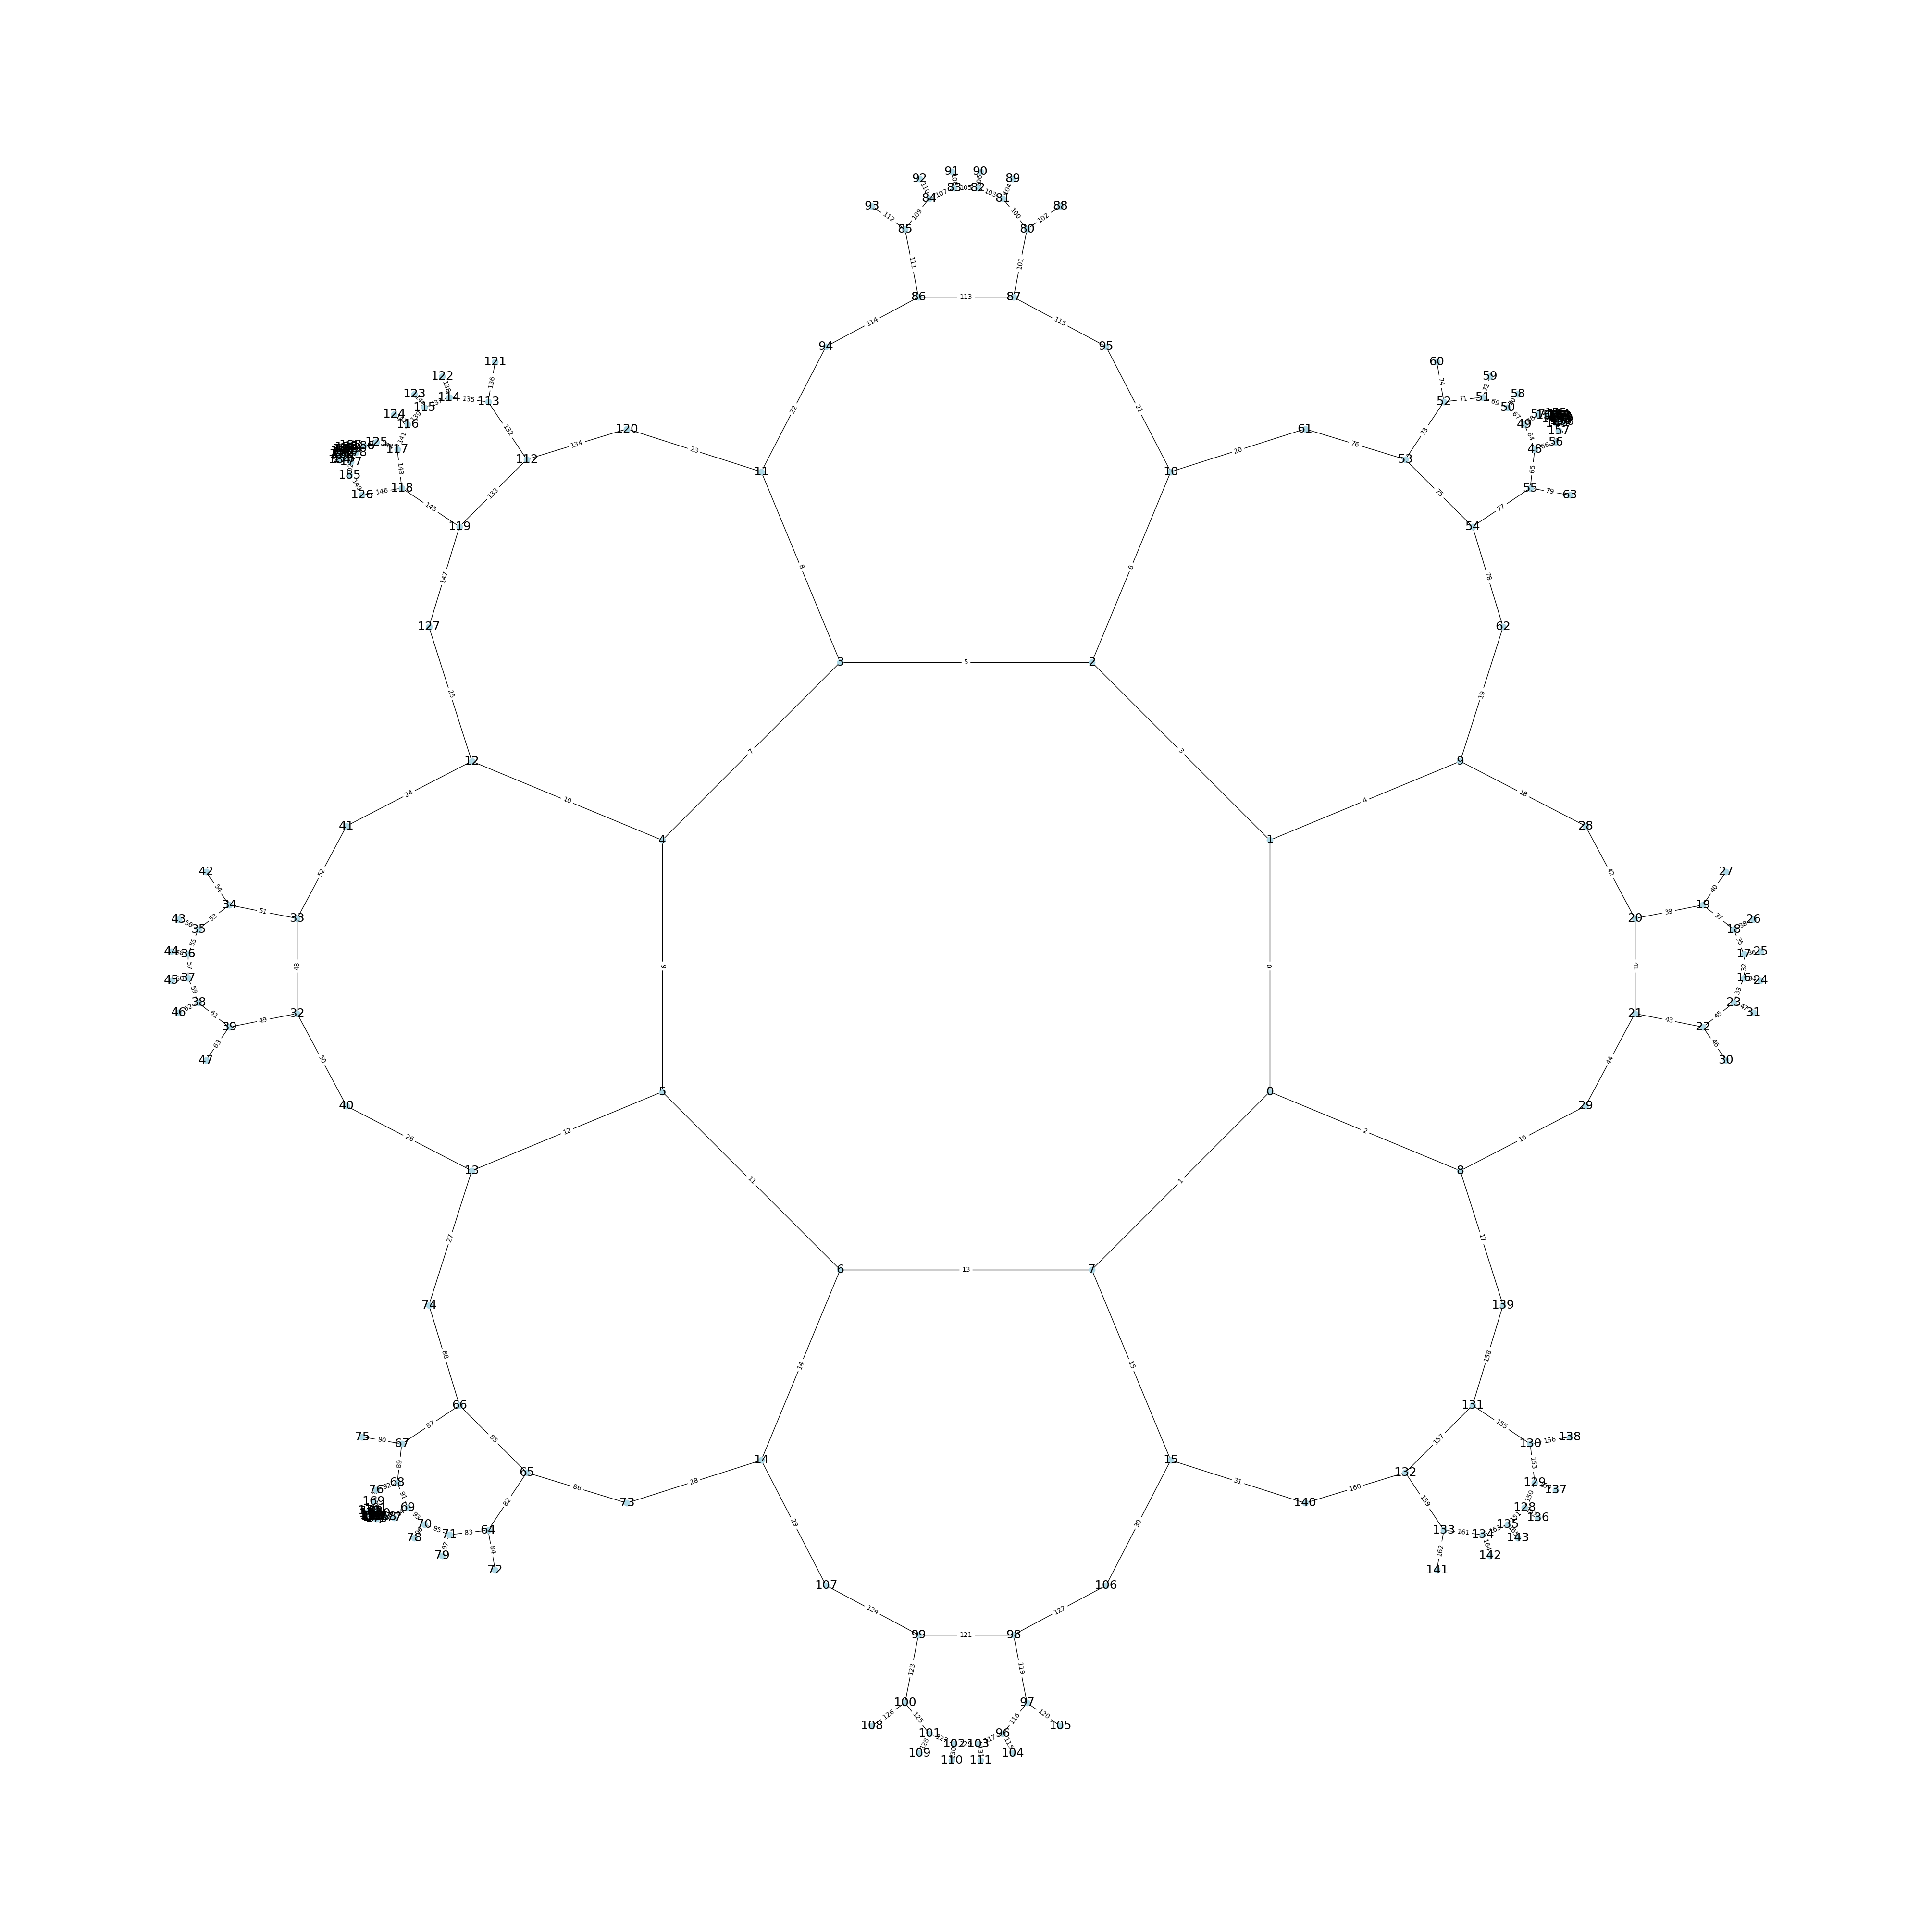

In [15]:
p = 8
q = 3

p_B = 8
q_B = 8
kappa = 1

unit_cell = unit_cell_positions(p,q)
Bolza_generators = Fuchsian_generators(p_B, q_B)
outer_ring = []

for generator in Bolza_generators:
    for vertex in unit_cell:
        new_vertex = create_new_vertex(vertex, generator)
        outer_ring.append(new_vertex)

extra_generators_indices = [(2,0), (3,1), (6,3)]
for index in extra_generators_indices:
    generator = Bolza_generators[index[0]] @ Bolza_generators[index[1]]
    for vertex in unit_cell:
        new_vertex = create_new_vertex(vertex, generator)
        outer_ring.append(new_vertex)


final_vertices = unit_cell + outer_ring

G = plot_vertices_with_edges(final_vertices)[0]

def add_periodicity_edges(graph, connections, vertex_to_edges, edge_to_vertices):
    edge_count = len(graph.edges())

    for source, targets in connections.items():
        for target in targets:
            graph.add_edge(source, target, with_labels=True)
            vertex_to_edges[tuple(sorted((source, target)))] = edge_count
            edge_to_vertices[edge_count] = tuple(sorted((source,target)))
            edge_count += 1
    
    coords = [(v.real, v.imag) for v in final_vertices]
    pos_dict = {idx: pos for idx, pos in enumerate(coords)}

    nx.draw(
        graph,
        pos=pos_dict,
        node_size=80,  # Adjust node size
        node_color="lightblue",
        with_labels=True,
        font_size=18,  # Increase font size for node labels
        font_color="black"
    )
    nx.draw_networkx_edge_labels(
        graph,
        pos=pos_dict,
        edge_labels=vertex_to_edges,
        font_size=10,  # Increase font size for edge labels
        label_pos=0.5,  # Adjust edge label position (closer to the center of edges)
    )
    return graph


In [16]:
def generate_circuit(graph, err_prob, vertex_to_edges):
    affected_edges = []
    num_vertices = len(graph.nodes())
    num_edges = len(graph.edges())
    
    vertices_qubits = QuantumRegister(num_vertices, 'vertices_qubits')
    edges_qubits = QuantumRegister(num_edges, 'edges_qubits')
    cr = ClassicalRegister(num_vertices, 'cr')
    #TODO We will still add classical registers for plaquettes
    qc = QuantumCircuit()
    qc.add_register(vertices_qubits)
    qc.add_register(edges_qubits)
    qc.add_register(cr)

    for j in range(len(edges_qubits)):
        random_number = np.random.rand()
        if random_number < err_prob:
            qc.x(edges_qubits[j])
            affected_edges.append(j)
            
    # for j in err_prob:
    #     qc.x(edges_qubits[j])
    #     affected_edges.append(j)
    # print('affected_edges', affected_edges)

    
    for v in range(len(graph.nodes())):
        incident_edges = get_edge_labels_for_vertex(graph, v, vertex_to_edges)
        for edge in incident_edges:
            qc.cx(edges_qubits[edge], vertices_qubits[v])

        qc.barrier()
        
    for v in range(len(graph.nodes())):
        qc.measure(vertices_qubits[v], cr[v])
    
    return qc, affected_edges

In [17]:
def generate_syndrome_graph(indices, graph):
    syndrome_graph = nx.Graph()
    for v in indices:
        syndrome_graph.add_node(v, label = True)

    for i, ver1 in enumerate(indices):
        for j, ver2 in enumerate(indices[i+1:], start=i+1):
            weight = nx.shortest_path_length(graph, source=ver1, target=ver2)
            syndrome_graph.add_edge(ver1, ver2, weight=weight)

    pos = nx.spring_layout(syndrome_graph)  # Positioning for better visualization
    # nx.draw(syndrome_graph, pos, with_labels=True, node_color="lightblue", node_size=500)

    edge_labels_with_weight = nx.get_edge_attributes(syndrome_graph, 'weight')  # Retrieve weights
    # nx.draw_networkx_edge_labels(syndrome_graph, pos, edge_labels=edge_labels_with_weight)

    # plt.show()
    return syndrome_graph

In [18]:
def find_correction_paths(syndrome_graph, circuit_graph):
    matching = nx.algorithms.matching.min_weight_matching(syndrome_graph)

    correction_paths = []
    # Print the matching
    # print("Minimum Weight Perfect Matching:", matching)
    for edge in matching:
        # print(edge, "with weight", syndrome_graph.edges[edge]['weight'])
        path = nx.shortest_path(circuit_graph, source=edge[0], target=edge[1])
        # print('path', path)
        correction_paths.append(path)
    return correction_paths
        


In [19]:
def get_edge_from_v1_v2(v1,v2, vertex_to_edges):
    tup = tuple(sorted((v1, v2)))
    return vertex_to_edges[tup]

def find_all_plaquette_edges(original_graph, vertex_to_edges):
    plaquettes = nx.minimum_cycle_basis(original_graph)
    all_plaquette_edges = []
    for plaquette_vertices in plaquettes:
        plaquette_edges = []
        i = 0
        for v in plaquette_vertices:
            # print(plaquette_vertices)
            plaquette_edges.append(get_edge_from_v1_v2(plaquette_vertices[i], plaquette_vertices[(i+1)%p], vertex_to_edges))
            i = i+1
        
        # all_plaquette_edges.append((plaquette_vertices, plaquette_edges))
    return all_plaquette_edges
            
# for k,v in all_plaquette_edges:
#     print(k,v)

In [20]:
# if the syndrome measurement plus the affected errors span two neighboring, then the function will detect a logic error while there is none

# print('affected_edges', sorted(affected_edges))
def get_logical_error(affected_edges, correction_paths, all_plaquette_edges, vertex_to_edges):
    affected_edges_set = set(affected_edges)
    all_correction_edges = set()
    for correction_path in correction_paths:
        for i in range(len(correction_path)-1):
            all_correction_edges.add(get_edge_from_v1_v2(correction_path[i],correction_path[i+1], vertex_to_edges))
    # print('correction_edg', sorted(all_correction_edges))
    
    if all_correction_edges == affected_edges_set: 
        return False

    # remove the common edges between affected and correction edges
    intersection = all_correction_edges.intersection(affected_edges_set)
    union = all_correction_edges.union(affected_edges_set)
    potential_plaquettes = union - intersection
    
    # print('potential_plaquettes', potential_plaquettes)
    # if something remains, check if they form plaquettes by looping over the 17 possible plaquettes
    if len(potential_plaquettes) % p != 0:
        return True
    
    for _,v in all_plaquette_edges:
        if set(v).issubset(potential_plaquettes):
            potential_plaquettes -= set(v)
    if len(potential_plaquettes) > 0:
        return True
    return False

# print(get_logical_error())
            

In [21]:
def error_graph(graph, original_graph, vertex_to_edges): 
    trials = 2
    error_probabilities = [0.05*j for j in range(11)]
    error_percentages = []
    for ep in error_probabilities:
        count = 0
        for i in range(trials):
            qcc, affected_edges = generate_circuit(graph, ep, vertex_to_edges)
            simulator = AerSimulator()
            result = simulator.run(qcc, shots=1).result().get_counts()
            syndrome_measurement = next(iter(result))[::-1]
            indices= [j for j, bit in enumerate(syndrome_measurement) if bit == "1"]
            # print('affected_edges', sorted(affected_edges))
            
            syndrome_graph = generate_syndrome_graph(indices, graph)
            correction_paths = find_correction_paths(syndrome_graph, graph)
            all_plaquette_edges = find_all_plaquette_edges(original_graph, vertex_to_edges)
            is_err = get_logical_error(affected_edges, correction_paths, all_plaquette_edges, vertex_to_edges)
            if is_err:
                count += 1
        error_percentages.append(count/trials)
    
    return error_percentages


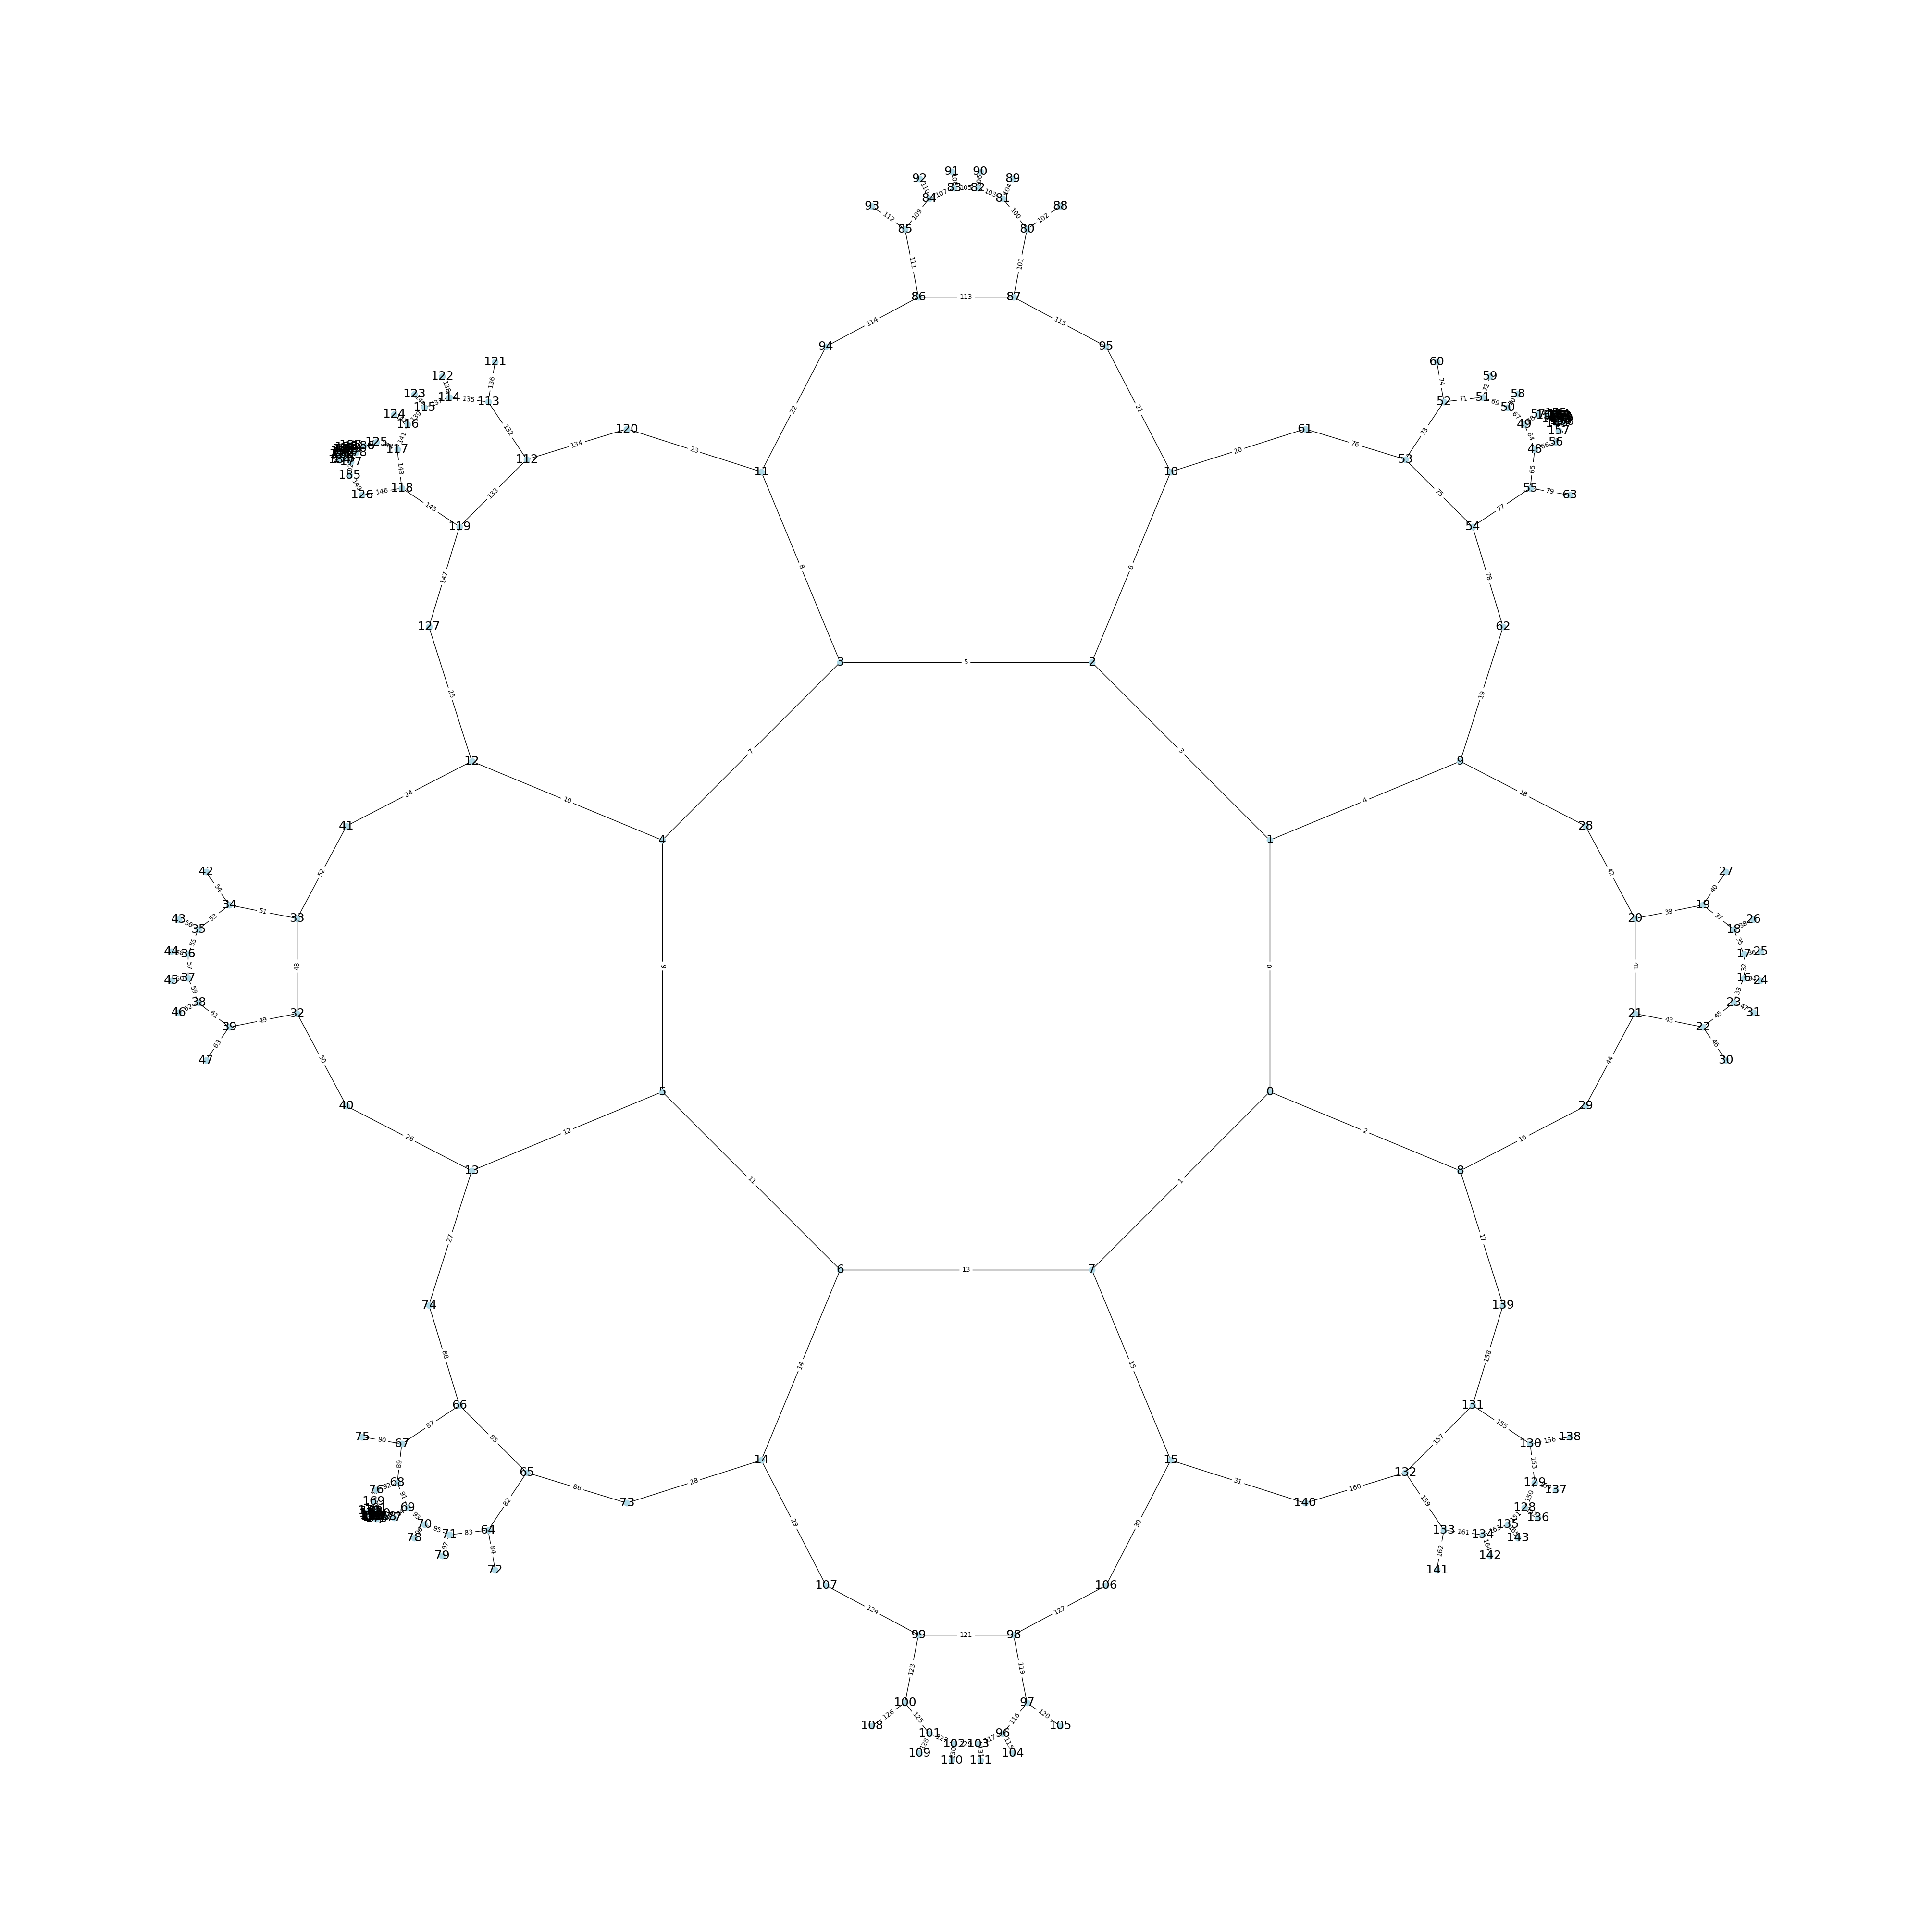

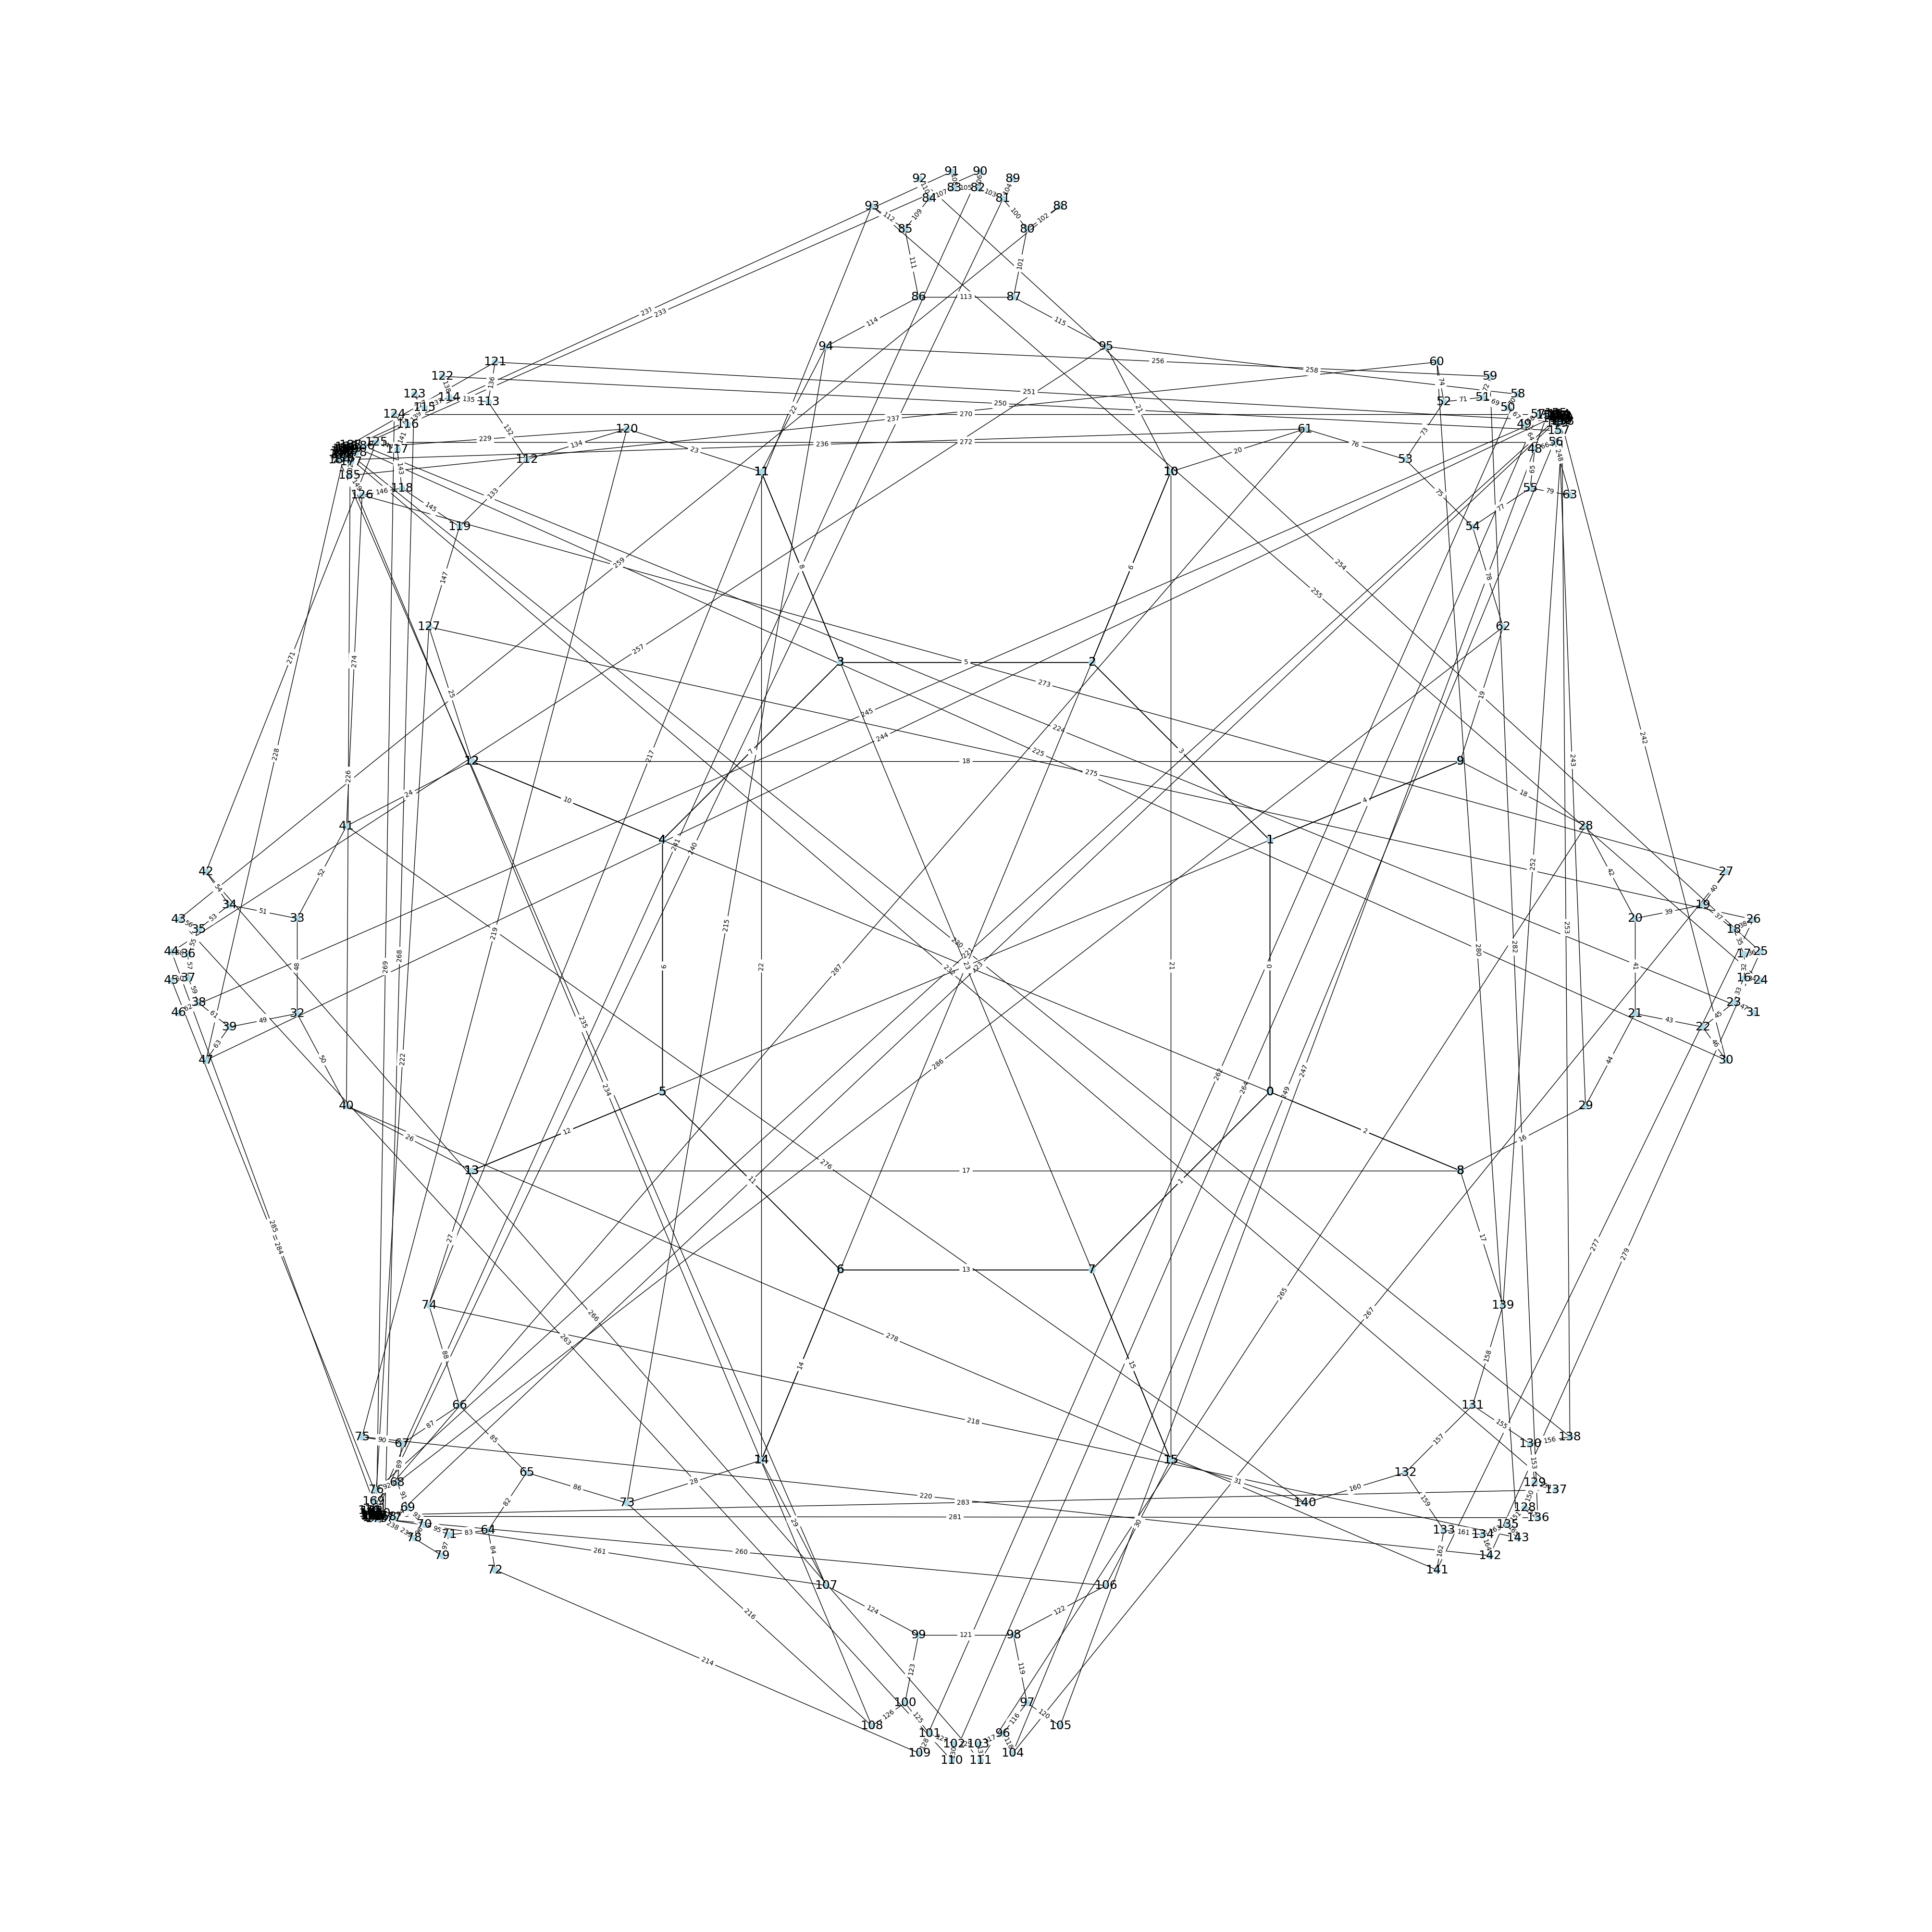

In [22]:
# error_graph(twelve_circuit_graph, twelve_face_original_graph)
twelve_face_graph, twelve_vertex_to_edges, twelve_edge_to_vertices = plot_vertices_with_edges(final_vertices)
one_face_graph, one_vertex_to_edges, one_edge_to_vertices = plot_vertices_with_edges(unit_cell)

twelve_face_original_graph = copy.deepcopy(twelve_face_graph)
one_face_original_graph = copy.deepcopy(one_face_graph)

#TODO bypassing hardcoded periodicity for now
twelve_circuit_graph = add_periodicity_edges(twelve_face_graph, twelve_face_connections, twelve_vertex_to_edges, twelve_edge_to_vertices)
one_circuit_graph = add_periodicity_edges(one_face_graph, one_face_connections, one_vertex_to_edges, one_edge_to_vertices)

one_err_percentage = error_graph(one_circuit_graph, one_face_original_graph, one_vertex_to_edges)
twelve_err_percentage = error_graph(twelve_circuit_graph, twelve_face_original_graph,  twelve_vertex_to_edges)

In [23]:
# twe_face_num_qubits = twelve_circuit_graph.number_of_edges()
# one_face_num_qubits = one_circuit_graph.number_of_edges()

In [24]:
# plt.figure(figsize=(8, 6))  # Set the figure size
# error_probabilities = [0.0025*j for j in range(11)]
# plt.plot(error_probabilities, one_err_percentage, marker='o', linestyle='-', color='b', label=f'[[n={one_face_num_qubits},k=4]]')
# plt.plot(error_probabilities, twelve_err_percentage, label=f'[[n={twe_face_num_qubits} , k = ]]', color="red", linestyle="--", marker="x")

# # Add labels and a title
# plt.xlabel('Error Probabilities')
# plt.ylabel('Error Percentages')
# plt.title('Error Threshold Graph')
# plt.legend()

# # Show the grid and the graph
# plt.grid(True)
# plt.show()

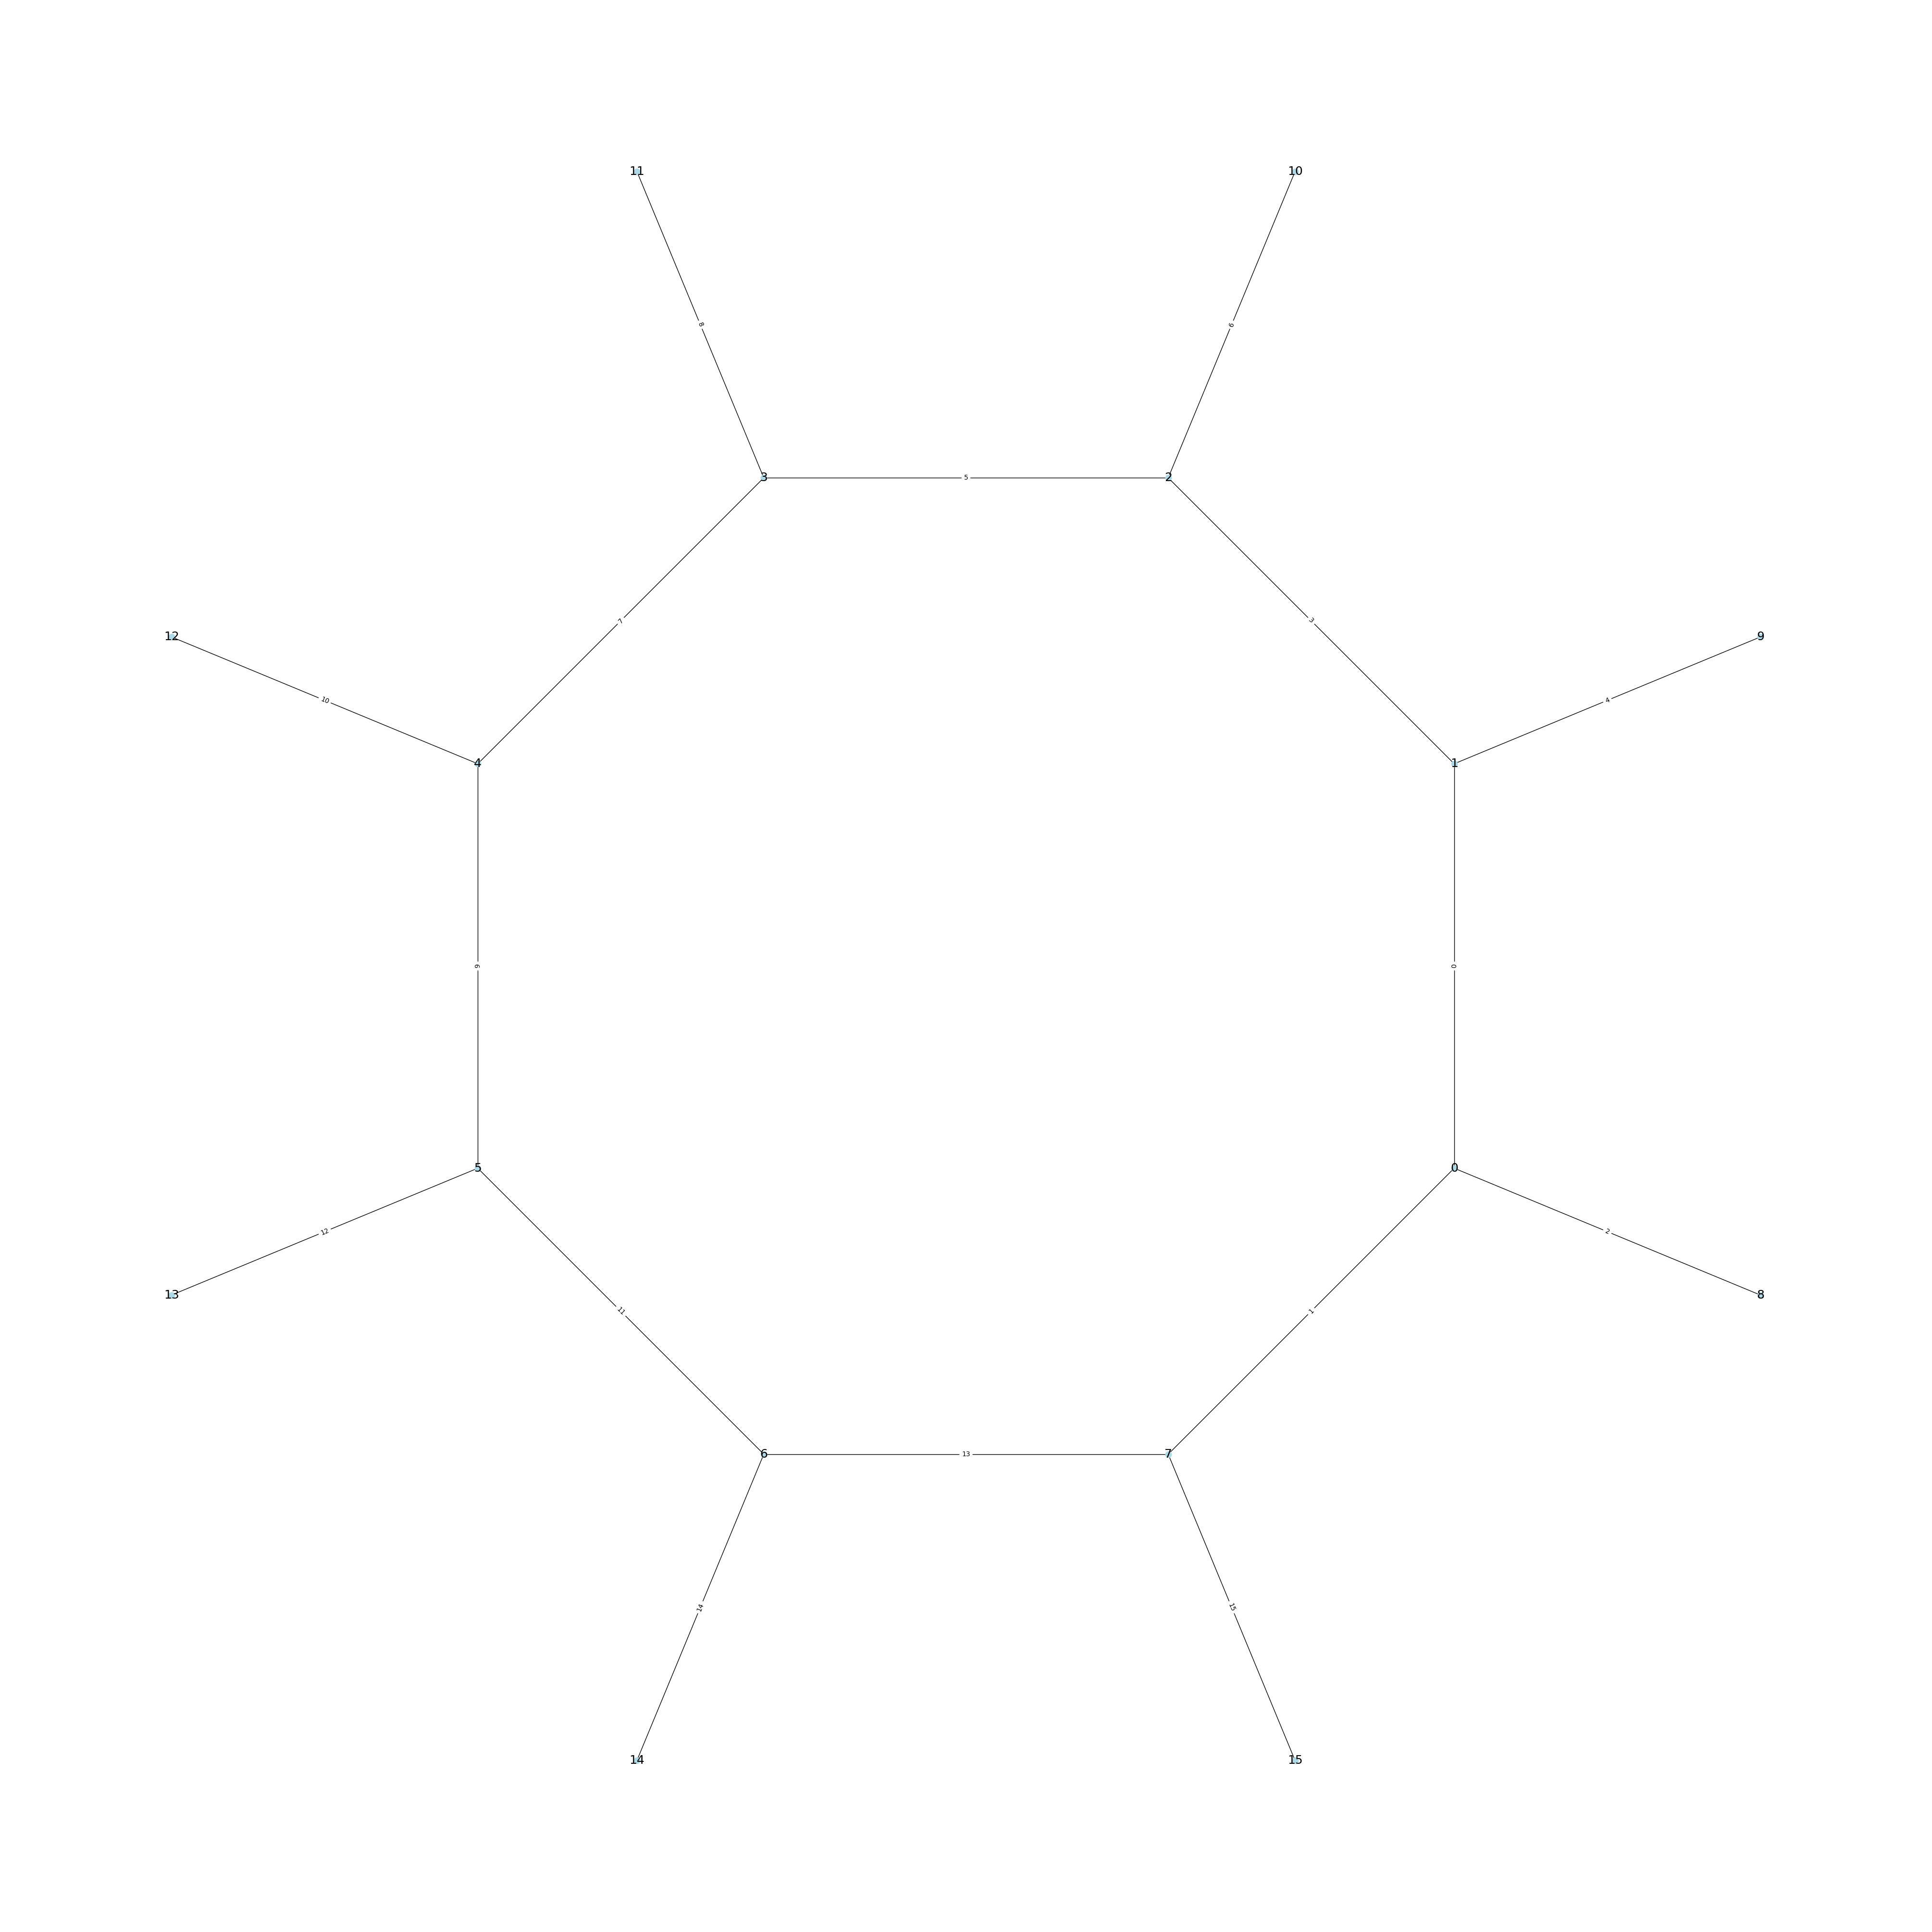

In [25]:
# Parameters
p_B = 8  # Number of generators of the Bravais lattice
N = 12    # Number of faces of the cluster
n = 16   # Number of vertices in the unit cell

unit_cell_graph = plot_vertices_with_edges(unit_cell)

V = nx.to_numpy_array(unit_cell_graph[0])  # Adjacency matrix of the unit cell
# Initialize the zero matrices
T_matrices = [np.zeros((n, n)) for _ in range(p_B)]

# Indices to be updated
T_indices = [
    [[9, 12], [8, 13]],
    [[12, 9], [13, 8]],
    [[9, 14], [10, 13]],
    [[14, 9], [13,10]],
    [[10, 15], [11, 14]],
    [[15,10], [14,11]],
    [[11, 8], [12, 15]], 
    [[8,11],[15,12]]]


# Update the T matrices
for j in range(p_B):
    for k, l in T_indices[j]:
        T_matrices[j][k, l] = 1


# Initialize A_l
I = np.identity(N)
A_l = np.kron(I, V)

# Define CT (from GAP)
CT9 = [ [ 2, 6, 1, 5, 8, 9, 3, 7, 4 ], [ 3, 1, 7, 9, 4, 2, 8, 5, 6 ], [ 4, 5, 9, 3, 1, 8, 6, 2, 7 ], [ 5, 8, 4, 1, 2, 7, 9, 6, 3 ], 
  [ 6, 9, 2, 8, 7, 4, 1, 3, 5 ], [ 7, 3, 8, 6, 9, 1, 5, 4, 2 ], [ 8, 7, 5, 2, 6, 3, 4, 9, 1 ], [ 9, 4, 6, 7, 3, 5, 2, 1, 8 ] ]

CT12 =[ [ 2, 9, 1, 10, 6, 8, 4, 3, 7, 12, 5, 11 ], [ 3, 1, 8, 7, 11, 5, 9, 6, 2, 4, 12, 10 ], 
  [ 4, 10, 7, 5, 1, 2, 11, 9, 12, 6, 3, 8 ], [ 5, 6, 11, 1, 4, 10, 3, 12, 8, 2, 7, 9 ], 
  [ 6, 8, 5, 2, 10, 12, 1, 11, 3, 9, 4, 7 ], [ 7, 4, 9, 11, 3, 1, 12, 2, 10, 5, 8, 6 ], 
  [ 8, 3, 6, 9, 12, 11, 2, 5, 1, 7, 10, 4 ], [ 9, 7, 2, 12, 8, 3, 10, 1, 4, 11, 6, 5 ] ]


# Perform the update to A_l based on CT
for alpha in range(p_B):  # Iterate over the T_matrices
    for i in range(N):
        # Create U matrix
        U = np.zeros((N, N))
        j = CT12[alpha][i] - 1  # Adjust indexing for Python (0-based)
        # if i != j:
        U[i, j] = 1
        # Update A_l
        A_l += np.kron(U, T_matrices[alpha])

In [26]:
from scipy.sparse import csr_matrix, coo_matrix

# Convert A_l to a sparse matrix (if not already sparse)
A_l_sparse = csr_matrix(A_l)

# Convert to COO format to access row, col, and data attributes
A_l_coo = coo_matrix(A_l_sparse)

# Define the file name
output_file = "sparse_matrix_12.txt"

# Save the sparse matrix to the file
with open(output_file, "w") as f:
    f.write("Sparse representation of A_l:\n")
    for i, j, v in zip(A_l_coo.row, A_l_coo.col, A_l_coo.data):
        f.write(f"({i}, {j})\t{v}\n")

print(f"Sparse matrix saved to {output_file}")

Sparse matrix saved to sparse_matrix_12.txt


In [27]:
import numpy as np
import scipy.sparse as sp

# Load the adjacency matrix from the file
file_path = "sparse_matrix_12.txt"  # Update with your actual file path
rows, cols, data = [], [], []

pairs = []
with open(file_path, "r") as f:
    for line in f:
        # Parse the line (example: "(0, 1)\t1.0")
        parts = line.strip().split("\t")
        if len(parts) == 2:
            indices, value = parts
            pair = eval(indices)  # Convert "(x, y)" to tuple (x, y)
            pairs.append(pair)
        else:
            print(parts)

for pair in pairs:
    inverse = (pair[1], pair[0])
    if inverse not in pairs:
        print(f"Pair {pair} not found in pairs")
# Construct the sparse matrix
# n = max(max(rows), max(cols)) + 1  # Get the matrix size
# adj_matrix = sp.coo_matrix((data, (rows, cols)), shape=(n, n))
# 
# # Check if the matrix is symmetric
# is_symmetric = (adj_matrix != adj_matrix.transpose()).nnz == 0
# 
# print("The adjacency matrix is symmetric:", is_symmetric)

['Sparse representation of A_l:']


In [28]:
import numpy as np
from scipy.sparse import csr_matrix

# Ensure A_l is in sparse format
A_l_sparse = csr_matrix(A_l)

# Count the number of nonzero elements in each column
column_counts = np.diff(A_l_sparse.indptr)

# Check if all columns have exactly 3 elements
if np.all(column_counts == 3):
    print("All columns have exactly 3 nonzero elements.")
else:
    print("Some columns do not have exactly 3 nonzero elements.")
    for col_idx, count in enumerate(column_counts):
        if count != 3:
            print(f"Column {col_idx} has {count} nonzero elements.")

All columns have exactly 3 nonzero elements.


In [29]:
def load_sparse_matrix(filename):
    """
    Load a sparse adjacency matrix from a text file into a dictionary.
    Assumes each line is formatted as '(row, column)\tvalue'.
    """
    sparse_matrix = {}
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split("\t")  # Ensure we split by TAB character
            if len(parts) != 2:
                continue  # Skip invalid lines
            
            try:
                # Extract row and column indices from the formatted string "(row, col)"
                row_col = parts[0].strip("()").split(",")
                row, col = int(row_col[0].strip()), int(row_col[1].strip())
                value = float(parts[1].strip())

                if value != 0:  # Store only nonzero elements
                    sparse_matrix[(row, col)] = value

            except ValueError:
                print(f"Warning: Skipping malformed line: {line.strip()}")
                continue  # Skip malformed lines
                
    return sparse_matrix

def check_adjacency_consistency(G, filename):
    """
    Check if every nonzero element in the adjacency matrix of G is also in the sparse matrix file.
    """
    sparse_matrix = load_sparse_matrix(filename)
    
    # Get adjacency matrix from NetworkX graph
    adj_matrix = nx.to_numpy_array(G)

    # Track if any errors occur
    errors_found = False

    # Iterate over all nonzero elements in the NetworkX adjacency matrix
    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            if adj_matrix[i, j] != 0:  # Check if nodes i and j are neighbors in G
                if (i, j) not in sparse_matrix and (j, i) not in sparse_matrix:  
                    print(f"The element ({i}, {j}) is not contained in the txt file.")
                    errors_found = True

    if not errors_found:
        print("All edges in the graph are correctly represented in the txt file.")

# Example usage
filename = "sparse_matrix_12.txt"  # Replace with the actual file path

check_adjacency_consistency(G, filename)

All edges in the graph are correctly represented in the txt file.
